In [1]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import datetime
import os
import sys

sys.path.insert(0,"../HUXt/code")
import huxt as H
import huxt_analysis as HA
import huxt_inputs as Hin

/opt/anaconda3/envs/huxt/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


HUXt includes a number of references runs that can be used to verify the current HUXt installation. No errors mean everything is as expected. Ignore ipywidgets warning if it occurs

In [4]:
from sunpy.coordinates.sun import L0


import pandas as pd 
import numpy as np
from astropy import units as u

In [5]:
#reading in Parker data files

df= pd.read_csv('../May_2024_CME_HUXt_data.csv')
df=df.dropna()
df

,time,source_surface_longitude,np,vp,wp,r^2
56,2024-05-01 06:03:24.038556,216.508177,14.062671,307.79834,40.058470,0.489258
61,2024-05-01 06:03:28.407597,216.507515,48.519432,289.66864,58.135025,0.489259
65,2024-05-01 06:03:31.902837,216.506986,34.993996,302.86676,45.168106,0.489259
66,2024-05-01 06:03:32.776677,216.506854,97.965560,263.11426,82.431465,0.489259
67,2024-05-01 06:03:33.650477,216.506722,1495.287600,67.63941,244.132190,0.489259
...,...,...,...,...,...,...
80200,2024-05-30 23:47:36.767188,171.182827,17.461962,326.59595,42.450104,0.469497
80201,2024-05-30 23:48:04.729291,171.178274,16.955605,337.04068,43.517850,0.469494
80202,2024-05-30 23:48:32.691375,171.173721,16.546144,342.24460,42.917835,0.469490
80203,2024-05-30 23:49:00.653459,171.169168,16.293299,339.47490,41.898240,0.469487


In [6]:
#accessing speed data for boundary conditions

parker_vr_dt= pd.to_datetime(df['time'])
parker_vr=df['vp'].values
parker_vr

array([307.79834, 289.66864, 302.86676, ..., 342.2446 , 339.4749 ,
       332.74634])

In [7]:
#setting up a 5 days simulation starting from the initial date for Parker data

sim_start_time = parker_vr_dt.min()
sim_duration = 5 * u.day

v_boundary_ts = np.array([
    np.ones(128) * v for v in parker_vr
]) * u.km/u.s  # shape: (N_times, n_bins)
v_boundary_ts

In [11]:
#organize Parker data by longitude, into 128 bins

#set up bins, bin by longitude


n_bins = 128
lon_bins = np.linspace(0, 360, n_bins +1)

lon_bins_center=(lon_bins[1:]+lon_bins[:-1])/2  #for plotting purposes

v_boundary = np.zeros(n_bins) * u.km/u.s
counts = np.zeros(n_bins)

#taking the mean of the speed data for each longitude bin, otherwise return 400km/s
for i in range(n_bins):
    current_bin = ( (df["source_surface_longitude"] >= lon_bins[i]) & (df["source_surface_longitude"] < lon_bins[i + 1]) )
    
    if current_bin.any():
        v_boundary[i] = df.loc[current_bin, "vp"].mean() * (u.km/u.s)
        counts[i] = current_bin.sum()
    else:
        v_boundary[i] = 400 * (u.km/u.s)  # fallback values for data gaps



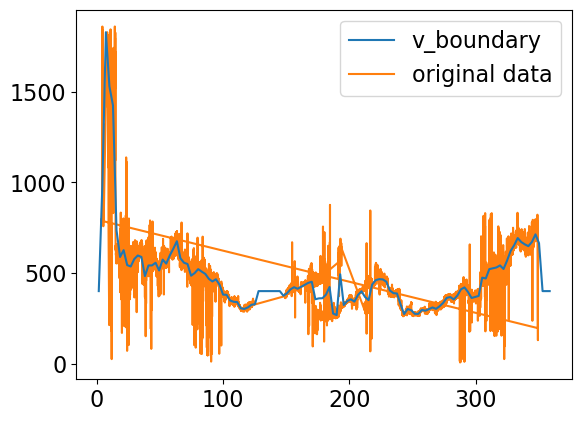

In [12]:
#plotting v_boundary

plt.plot(lon_bins_center, v_boundary, label='v_boundary', zorder=3)
plt.plot(df['source_surface_longitude'], parker_vr, label='original data')
plt.legend()

In [ ]:
#set up HUXt model


#sim_start_time = df["time"].min()
#sim_duration = 5 * u.day

cr, cr_lon_init = Hin.datetime2huxtinputs(sim_start_time)

model = H.HUXt(v_boundary=v_boundary, cr_num=cr, cr_lon_init=cr_lon_init, simtime=sim_duration, dt_scale=4, r_min=21.5 * u.solRad)

model.solve([], tag='psp_binned_May_2025') #solve these conditions


#Predict Wind Speed at Earth
r=1 * u.AU
HA.plot_timeseries(model, r, lon=0 * u.deg, tag='psp_binned_earth')

Rendering 200 frames. Expected time: 40 secs
mp4 file written to /home/sbadman/1_RESEARCH/GIT_REPOS/HUXt_REU_project/HUXt/figures/HUXt_CR2283_psp_no_cme_run_movie.mp4


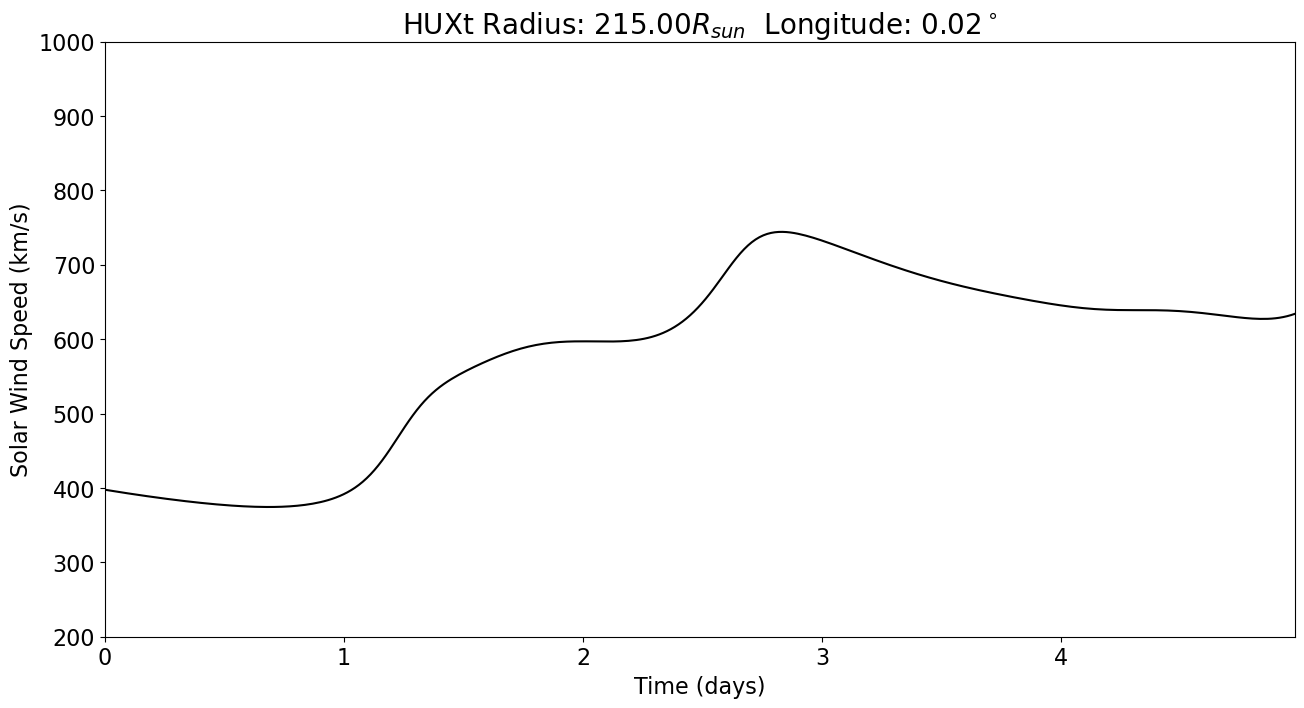

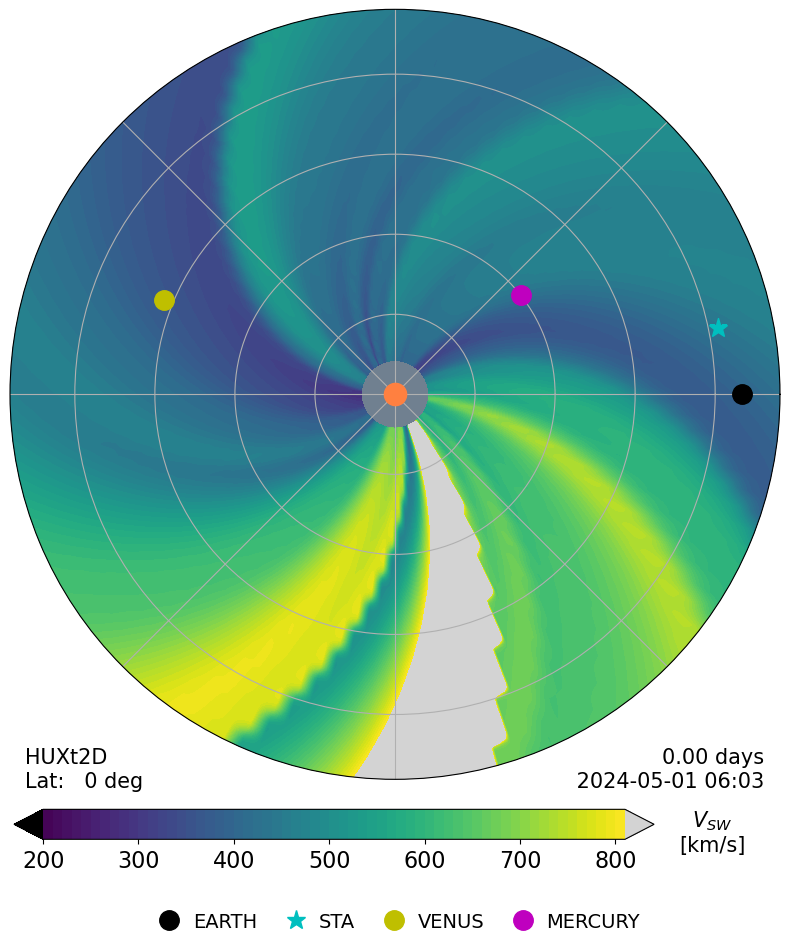

In [ ]:
HA.animate(model, tag='psp_no_cme_run')

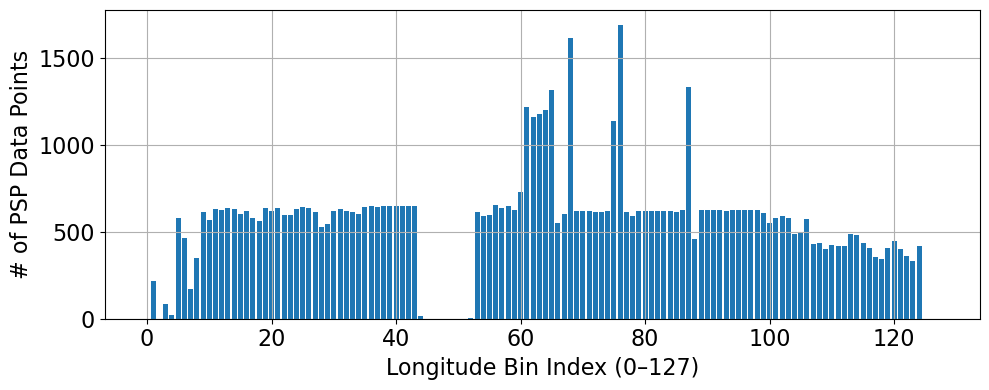

In [14]:
#plot bins
plt.figure(figsize=(10, 4))
plt.bar(np.arange(n_bins), counts)
plt.xlabel("Longitude Bin Index (0–127)")
plt.ylabel("# of PSP Data Points")
#plt.title("PSP Data Coverage by Longitude Bin")
plt.grid(True)
plt.tight_layout()
plt.show()


(<Figure size 1400x700 with 1 Axes>,
 <Axes: title={'center': 'HUXt Radius: 215.00$R_{sun}$  Longitude: 0.02$^\\circ$'}, xlabel='Time (days)', ylabel='Solar Wind Speed (km/s)'>)

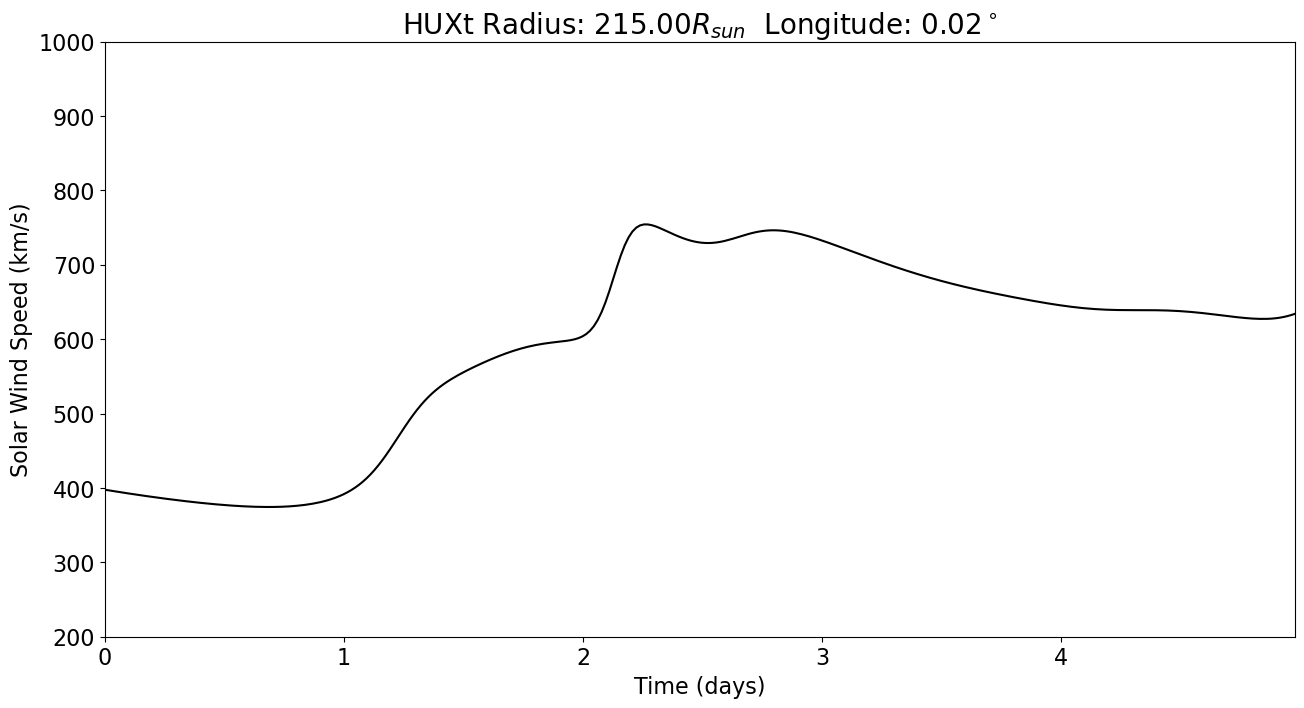

In [15]:
#Example, Inject a CME

# CME parameters — customize as needed
cme = H.ConeCME(
    t_launch=0 * u.day,
    longitude=0 * u.deg,
    latitude=0 * u.deg,
    width=30 * u.deg,
    v=1000 * u.km/u.s,
    thickness=5 * u.solRad,
    initial_height=21.5 * u.solRad   # MUST match model's r_min
)


# Add to list
cme_list = [cme]



model = H.HUXt(
    v_boundary=v_boundary,
    cr_num=cr,
    cr_lon_init=cr_lon_init,
    simtime=5 * u.day,
    dt_scale=4,
    r_min=21.5 * u.solRad
)

model.solve(cme_list, tag='psp_cme_run')


r=1 * u.AU
HA.plot_timeseries(model, r, lon=0 * u.deg, tag='psp_binned_earth')

In [26]:
!pip install ipympl

  Using cached ipywidgets-8.1.7-py3-none-any.whl.metadata (2.4 kB)
  Using cached widgetsnbextension-4.0.14-py3-none-any.whl.metadata (1.6 kB)
  Using cached jupyterlab_widgets-3.0.15-py3-none-any.whl.metadata (20 kB)
Using cached ipywidgets-8.1.7-py3-none-any.whl (139 kB)
Using cached jupyterlab_widgets-3.0.15-py3-none-any.whl (216 kB)
Using cached widgetsnbextension-4.0.14-py3-none-any.whl (2.2 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [ipympl]


In [27]:
#Example, Animate

%matplotlib ipympl
h=HA.animate(model, tag='psp_cme_run')

Rendering 200 frames. Expected time: 40 secs


<IPython.core.display.Javascript object>

mp4 file written to /home/sbadman/1_RESEARCH/GIT_REPOS/HUXt_REU_project/HUXt/figures/HUXt_CR2283_psp_cme_run_movie.mp4


In [21]:
%matplotlib notebook
from IPython.display import HTML
h

In [38]:
H.HUXt?

Init signature:
H.HUXt(
    v_boundary=<Quantity nan km / s>,
    b_boundary=nan,
    cr_num=nan,
    cr_lon_init=<Quantity 360. deg>,
    latitude=<Quantity 0. deg>,
    r_min=<Quantity 30. solRad>,
    r_max=<Quantity 240. solRad>,
    lon_out=<Quantity nan rad>,
    lon_start=<Quantity nan rad>,
    lon_stop=<Quantity nan rad>,
    simtime=<Quantity 5. d>,
    dt_scale=1.0,
    frame='synodic',
    input_v_ts=<Quantity nan km / s>,
    input_b_ts=nan,
    input_iscme_ts=nan,
    input_t_ts=<Quantity nan s>,
    track_cmes=True,
)
Docstring:     
A class containing the HUXt model described in Owens et al. (2020, DOI: 10.1007/s11207-020-01605-3)

Users must specify the solar wind speed boundary condition through the v_boundary keyword
argument. Failure to do so defaults to a 400 km/s boundary.

Model coordinate system is HEEQ radius and longitude.

Attributes:
    cmes: A list of ConeCME instances used in the model solution.
    cme_expansion: Whether CMEs are inserted with a declinin